# IDB (ICAO Datastructure for Barcode) v.1.2.0 Encoding/Decoding

### Setting up the project

The barcode encoder/decoder is based on the ```construct``` library for Python, which let's you create parsers (and builders) for binary data in a declarative manner.   
As a first step we setup the environement by loading all the needed libraries, then creating some ```Adapter```s and ```Tunnel```s for our specific use-case.

In [1]:
import base64
from construct import *

setGlobalPrintFullStrings(True)
setGlobalPrintFalseFlags(True)

class Base32(Tunnel):
    def _decode(self, obj, context, path):
        obj = obj + b"=" * ((8 - len(obj) % 8) % 8)
        return base64.b32decode(obj)

    def _encode(self, obj, context, path):
        return base64.b32encode(obj).strip(b"=")

class C40(Adapter):
    def _decode(self, obj, context, path):
        chset = "*** 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        output = ''
        for b1, b2  in [(obj[i:] + b"\x00")[0:2] for i in range(0, len(obj), 2)]:
            if b1 == 254:
                output += chr(b2 - 1)
                break
            u = (b1 * 256) + b2
            u1 = int((u - 1) / 1600)
            u2 = int((u - (u1 * 1600) - 1) / 40)
            u3 = int(u - (u1 * 1600) - (u2 * 40) - 1)
            output += chset[u1] + chset[u2] + chset[u3]
        return output

    def _encode(self, obj, context, path):
        obj = obj.encode()
        chset = "*** 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        output = b''
        for u1, u2, u3 in [(obj[i:] + b"\x00\x00")[0:3] for i in range(0, len(obj), 3)]:
            if u2 == 0:
                output += b"\xfe" + (u1 + 1).to_bytes()
                break
            u1 = chset.index(chr(u1))
            u2 = chset.index(chr(u2))
            u3 = 0 if u3 == 0 else chset.index(chr(u3))
            u = 1600*u1 + 40*u2 + u3 + 1
            output += int(u / 256).to_bytes() + int(u % 256).to_bytes()
        return output

class StripLT(Adapter):
    def _decode(self, obj, context, path):
        return obj.replace(" ", "<")

    def _encode(self, obj, context, path):
        return obj.replace("<", " ")

### Creating the datastructures

Here we declare all the datastructures needed to parse IDB barcodes.

In [2]:
msg_mrz_td1 = FocusedSeq(
    "mrz",
    Const(b"\x07"),
    Const(b"\x3c"), # Fixed-lenght: 60
    "mrz" / StripLT(C40(Bytes(60)))
)

msg_mrz_td3 = FocusedSeq(
    "mrz",
    Const(b"\x08"),
    Const(b"\x3c"), # Fixed-lenght: 60
    "mrz" / StripLT(C40(Bytes(60)))
)

msg_can = FocusedSeq(
    "code",
    Const(b"\x09"),
    Const(b"\x04"), # Fixed-lenght: 4
    "code" / C40(Bytes(4))
)

msg_photo = FocusedSeq(
    "p",
    Const(b"\xF0"),
    "p" / Prefixed(VarInt, GreedyBytes)
)

msg_signer_certificate = FocusedSeq(
    "sc",
    Const(b"\x7f"),
    "sc" / Prefixed(VarInt, GreedyBytes)
)

msg_signature_data = FocusedSeq(
    "sd",
    Const(b"\x7f"),
    "sd" / Prefixed(VarInt, GreedyBytes)
)

idb1_message = Struct(
    "header" / Struct (
        "country_identifier"      / C40(Bytes(2)),
        #"signature_algorithm"     / If(this._._.flags.signed, Bytes(1)),
        #"certificate_reference"   / If(this._._.flags.signed, Bytes(5)),
        #"signature_creation_date" / If(this._._.flags.signed, Bytes(4))
    ),
        
    Const(b"\x61"), # Message start
    "message" / Prefixed(VarInt, Struct (
        "mrz_td1" / Optional(msg_mrz_td1),
        "mrz_td3" / Optional(msg_mrz_td3),
        "can" / Optional(msg_can),
        "photo" / Optional(msg_photo)
    )),

    "signer_certificate" / Optional(msg_signer_certificate),
    "signature_data" / Optional(msg_signature_data)
)

idb1 = Struct(
                    Const(b"NDB1"), # IDB Version 1 Signature
    "flags"       / FlagsEnum(
                        ExprAdapter(Byte, obj_ - 0x41, obj_ + 0x41),
                        signed = 1,
                        compressed = 2),
    "content" / IfThenElse(this.flags.compressed, Base32(Compressed(idb1_message, "zlib", level=9)), Base32(idb1_message))
)

# Testing Barcode 1

First we parse a barcode, then we build a new one using the same data and check that the two barcodes are identical.

### Parse

In [3]:
barcode = b"NDB1CPDNLW6JU2GHN3JSL7LJCNNLZY2SYC34ENVQNBDOV7O6ENHM2U3BLNG2HUFRM5JPZWMKTPW4I6KWPVMXEIL3RNCBIAAF4KFW5"
print("Barcode content:", idb1.parse(barcode))

Barcode content: Container: 
    flags = Container: 
        signed = False
        compressed = True
    content = Container: 
        header = Container: 
            country_identifier = u'UTO' (total 3)
        message = Container: 
            mrz_td1 = u'I<UTOD231458907<<<<<<<<<<<<<<<7408122F1204159UTO<<<<<<<<<<<6ERIKSSON<<ANNA<MARIA<<<<<<<<<<' (total 90)
            mrz_td3 = None
            can = None
            photo = None
        signer_certificate = None
        signature_data = None


### Build

In [4]:
m = {
    "flags": {
        "compressed": True
    },
    "content": {
        "header": {
            "country_identifier": "UTO"
        },
        "message": {
            "mrz_td1": "I<UTOD231458907<<<<<<<<<<<<<<<7408122F1204159UTO<<<<<<<<<<<6ERIKSSON<<ANNA<MARIA<<<<<<<<<<"
        }
    }
}

out = idb1.build(m)
print(out)
print("Equal:", out == barcode)

b'NDB1CPDNLW6JU2GHN3JSL7LJCNNLZY2SYC34ENVQNBDOV7O6ENHM2U3BLNG2HUFRM5JPZWMKTPW4I6KWPVMXEIL3RNCBIAAF4KFW5'
Equal: True


# Testing Barcode 2

### Parse

In [5]:
barcode = b"NDB1CPDNLW6JU2GHMGZXL5VFQO5ZI6YXF42NTYOUDIRWYAYCQNOUFA4SWTRG4HTVJG27UE42NY64VTIDFZTXWT4QQAVTDC3PQ"
print("Barcode content:", idb1.parse(barcode))

Barcode content: Container: 
    flags = Container: 
        signed = False
        compressed = True
    content = Container: 
        header = Container: 
            country_identifier = u'UTO' (total 3)
        message = Container: 
            mrz_td1 = None
            mrz_td3 = u'P<UTOSPECIMEN<<PETER<<<<<<<<<<<<<<<<<<<<<<<<K7629352E7UTO8504279M2805203<<<<<<<<<<<<<<00' (total 88)
            can = None
            photo = None
        signer_certificate = None
        signature_data = None


### Build

In [6]:
m = {
    "flags": {
        "compressed": True
    },
    "content": {
        "header": {
            "country_identifier": "UTO"
        },
        "message": {
            "mrz_td3": "P<UTOSPECIMEN<<PETER<<<<<<<<<<<<<<<<<<<<<<<<K7629352E7UTO8504279M2805203<<<<<<<<<<<<<<00"
        }
    }
}

out = idb1.build(m)
print(out)
print("Equal:", out == barcode)

b'NDB1CPDNLW6JU2GHMGZXL5VFQO5ZI6YXF42NTYOUDIRWYAYCQNOUFA4SWTRG4HTVJG27UE42NY64VTIDFZTXWT4QQAVTDC3PQ'
Equal: True


# Testing Barcode 3

### Parse

In [7]:
barcode = b"NDB1A3HCWCBQJAQQLGRVH"
print("Barcode content:", idb1.parse(barcode))

Barcode content: Container: 
    flags = Container: 
        signed = False
        compressed = False
    content = Container: 
        header = Container: 
            country_identifier = u'UTO' (total 3)
        message = Container: 
            mrz_td1 = None
            mrz_td3 = None
            can = u'156782' (total 6)
            photo = None
        signer_certificate = None
        signature_data = None


### Build

In [8]:
m = {
    "flags": {
        "compressed": False
    },
    "content": {
        "header": {
            "country_identifier": "UTO"
        },
        "message": {
            "can": "156782"
        }
    }
}

out = idb1.build(m)
print(out)
print("Equal:", out == barcode)

b'NDB1A3HCWCBQJAQQLGRVH'
Equal: True


# Testing Barcode 4

### Parse

In [9]:
barcode = b"NDB1CPDNLW6JUSGGZGRLBWPNXEAAWXEB5G"
print("Barcode content:", idb1.parse(barcode))

Barcode content: Container: 
    flags = Container: 
        signed = False
        compressed = True
    content = Container: 
        header = Container: 
            country_identifier = u'UTO' (total 3)
        message = Container: 
            mrz_td1 = None
            mrz_td3 = None
            can = u'156782' (total 6)
            photo = None
        signer_certificate = None
        signature_data = None


### Build

In [10]:
m = {
    "flags": {
        "compressed": True
    },
    "content": {
        "header": {
            "country_identifier": "UTO"
        },
        "message": {
            "can": "156782"
        }
    }
}

out = idb1.build(m)
print(out)
print("Equal:", out == barcode)

b'NDB1CPDNLW6JUSGGZGRLBWPNXEAAWXEB5G'
Equal: True


# Testing Barcode 5

### Parse

In [11]:
barcode = b"NDB1CPDNLW6JU2GC4GZXL5VFQO5ZI6YXF42NTYOUDIRWYAYCQNOUFA4SWTRG4HTVJG27UE42NY64VTIDFZTXWT4QSPC6CM236KAHFKEMLE"
print("Barcode content:", idb1.parse(barcode))

Barcode content: Container: 
    flags = Container: 
        signed = False
        compressed = True
    content = Container: 
        header = Container: 
            country_identifier = u'UTO' (total 3)
        message = Container: 
            mrz_td1 = None
            mrz_td3 = u'P<UTOSPECIMEN<<PETER<<<<<<<<<<<<<<<<<<<<<<<<K7629352E7UTO8504279M2805203<<<<<<<<<<<<<<00' (total 88)
            can = u'156782' (total 6)
            photo = None
        signer_certificate = None
        signature_data = None


### Build

In [12]:
m = {
    "flags": {
        "compressed": True
    },
    "content": {
        "header": {
            "country_identifier": "UTO"
        },
        "message": {
            "mrz_td3": "P<UTOSPECIMEN<<PETER<<<<<<<<<<<<<<<<<<<<<<<<K7629352E7UTO8504279M2805203<<<<<<<<<<<<<<00",
            "can": "156782"
        }
    }
}

out = idb1.build(m)
print(out)
print("Equal:", out == barcode)

b'NDB1CPDNLW6JU2GC4GZXL5VFQO5ZI6YXF42NTYOUDIRWYAYCQNOUFA4SWTRG4HTVJG27UE42NY64VTIDFZTXWT4QSPC6CM236KAHFKEMLE'
Equal: True


# Testing photo embedding

### Preparing photo

Original:


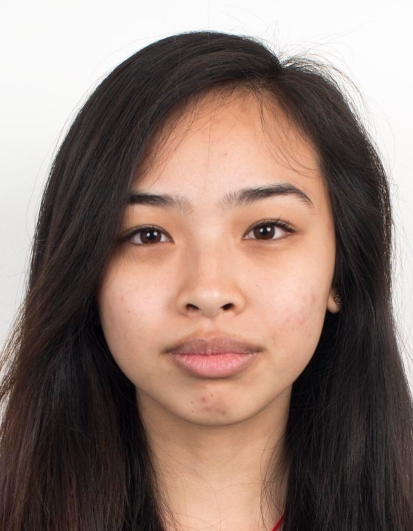


Resized:


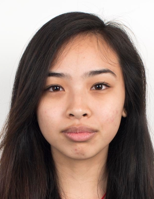


Compressed (1439 Bytes):


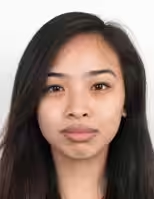

In [13]:
from PIL import Image, ImageOps
from IPython.display import display
import pillow_avif
import io

original = Image.open("original.jpg")
resized = original.resize((int(x*0.375) for x in original.size))
buffer = io.BytesIO()
resized.save(buffer, "AVIF", optimize=True, quality=40, quality_layers=[40])
print("Original:")
display(original)
print()
print("Resized:")
display(resized)
print()
print(f"Compressed ({buffer.getbuffer().nbytes} Bytes):")
display(Image.open(buffer))

### Embedding the photo into a barcode

In [14]:
m = {
    "flags": {
        "compressed": True
    },
    "content": {
        "header": {
            "country_identifier": "UTO"
        },
        "message": {
            "photo": buffer.getvalue()
        }
    }
}

out = idb1.build(m)
print(out)
print("Len:", len(out), "characters")

b'NDB1CPDNE3DYJGDNWSGGGCMCIW2EEW2VEKKVUEFGBH53O5NLEPF3CDNGCYJKC7AR7FD5ECFQ2LF3OKXRWRV6RCJKMOFVBKZ5GVHNNUPXKGEOVKLVFM5NMULOWK25DY7HL4M7PHTX7HG3PT3373BU2JFCYVSYFRIIAQBCFMHDICJAWICI4ZEDNUUBBIPAVEBI5Z3PQ6YJLIQQNMWJCAXYKCMPBEFPTOWDIAAEZBH4V6RIBYHPWFFCBQBE72DFBSLLAFITI4RW6HOHNUFPSQVADAKIUTWWOASAGRST7N42SIJSU5KVSHMLQPADVUFHN6PFAQAEMAES7UIYASJUREVIDDBQORV6V24S52KTJAQELBALNEAWS6LZPCESREC7POADKFNENKTE3JKEYNBZBIW4SBSD4RHUWUDOQASH56Y24SYJSKCUXGMUSVN4NIEASCMEVCUCQ26OKNZ5A6YL7NHRWL2KUOBWJEDWKBNTXZ6KMKK2ZX6D3SSQTWVPI6PWN3VOLESVTBAZUQKYTZXQK65DLME5YWOKH5DUM4A4KXW7H2HMC72AXZPUV4C5ZN7XSDOYBX56DWHDFZTCUXHDZYGS7GO4NFU7THURZM2LYPA7SRV4YMWTREZTTVTGSZXAF5JOCR53WNMTLVP65TTMSVW6T5XSORUFRKPONKD6PBNGF4SCVPFACYRNGBEIQTWU3K6CRI467WGSTXBI5M54S5ENCE725EP642S7UWNLGSTYDHMDETNSYVZ2EZIZCF7SCY364JYUU5GGMC3Q752GPK7WGFN3FU3UAXEXOGKGNR5H7JJ462D4PXHBX2ES3ZVKC7WL4TTXZENVO7AYN5LYIH3OHF6YVAKINXZW4ZPTB64A5VEA5LISNAXGS3HNVTPPQPPYBIWTPGYRZI6KFR47DDM7M7CTWSYUQWLG7BK5YYYR7C5LSJRA4ESO6HX4JJB2T25WVZOTDDHAXASWR3RWN4XOBZPBHECUX7BQZ7XGII

### Read the photo from the barcode

Container: 
    flags = Container: 
        signed = False
        compressed = True
    content = Container: 
        header = Container: 
            country_identifier = u'UTO' (total 3)
        message = Container: 
            mrz_td1 = None
            mrz_td3 = None
            can = None
            photo = b'\x00\x00\x00 ftypavif\x00\x00\x00\x00avifmif1miafMA1B\x00\x00\x00\xf2meta\x00\x00\x00\x00\x00\x00\x00(hdlr\x00\x00\x00\x00\x00\x00\x00\x00pict\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00libavif\x00\x00\x00\x00\x0epitm\x00\x00\x00\x00\x00\x01\x00\x00\x00\x1eiloc\x00\x00\x00\x00D\x00\x00\x01\x00\x01\x00\x00\x00\x01\x00\x00\x01\x1a\x00\x00\x04\x85\x00\x00\x00(iinf\x00\x00\x00\x00\x00\x01\x00\x00\x00\x1ainfe\x02\x00\x00\x00\x00\x01\x00\x00av01Color\x00\x00\x00\x00jiprp\x00\x00\x00Kipco\x00\x00\x00\x14ispe\x00\x00\x00\x00\x00\x00\x00\x9a\x00\x00\x00\xc7\x00\x00\x00\x10pixi\x00\x00\x00\x00\x03\x08\x08\x08\x00\x00\x00\x0cav1C\x81\x00\x0c\x00\x00\x00\x00\x13colrnclx\x00\x01\x0

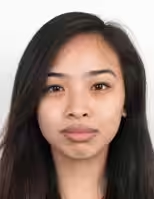

In [16]:
parsed = idb1.parse(out)
print(parsed)

print()
print("Photo from barcode:")
buffer2 = io.BytesIO()
buffer2.write(parsed.content.message.photo)
display(Image.open(buffer2))